# Entropy, Cross-Entropy, and Softmax for Multiclass Classification

## 🎯 The Core Questions

**Questions we'll answer:**

1. **What is entropy?** How do we measure uncertainty in probability distributions?
2. **What is cross-entropy?** How do we measure the difference between two distributions?
3. **What is softmax?** How do we convert raw scores to probabilities?
4. **Why do they work together?** The deep information-theoretic connection
5. **How do we use them?** Complete multiclass classification example

---

## 📋 What This Notebook Covers

1. **Entropy**: Measuring uncertainty and information content
2. **Cross-Entropy Loss**: The perfect loss function for classification
3. **Softmax Activation**: Converting logits to probabilities
4. **Entropy-Softmax Relationship**: Maximum entropy principle
5. **Complete Example**: Multiclass classification with Iris dataset
6. **Summary**: Putting it all together

Let's dive in! 🚀

## 1. Setup and Imports

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(42)

print("✅ Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")

✅ Libraries imported successfully!
NumPy version: 2.0.2


## 2. Entropy: Measuring Uncertainty

### 🎲 The Intuition

**Entropy** measures the **uncertainty** or **surprise** in a probability distribution.

**Think of it like this:**
- **Low entropy**: Very certain (e.g., 90% chance of rain)
- **High entropy**: Very uncertain (e.g., 33% chance of each of 3 outcomes)

### 📐 Mathematical Definition

For a discrete probability distribution $p = [p_1, p_2, ..., p_n]$:

$$H(p) = -\sum_{i=1}^{n} p_i \log(p_i)$$

**Key properties:**
- $H(p) \geq 0$ (always non-negative)
- $H(p) = 0$ when one probability is 1 (certain)
- $H(p)$ is maximum when all probabilities are equal (uniform)
- Uses natural log for nats, log base 2 for bits

**Convention:** $0 \log(0) = 0$ (by continuity)

In [12]:
def entropy(p):
    """
    Calculate entropy of a probability distribution.
    H(p) = -Σ p_i * log(p_i)
    """
    p = np.array(p)
    p = p[p > 0]  # Remove zeros to avoid log(0)
    return -np.sum(p * np.log(p))

# Test with different distributions
print("🎲 Entropy Examples:\n")

p1 = [0.9, 0.05, 0.05]
print(f"Distribution: {p1}")
print(f"Entropy: {entropy(p1):.4f} nats")
print(f"Interpretation: Very certain (low entropy)\n")

p2 = [0.6, 0.3, 0.1]
print(f"Distribution: {p2}")
print(f"Entropy: {entropy(p2):.4f} nats")
print(f"Interpretation: Moderately uncertain\n")

p3 = [1/3, 1/3, 1/3]
print(f"Distribution: {p3}")
print(f"Entropy: {entropy(p3):.4f} nats")
print(f"Interpretation: Maximum entropy (uniform)\n")

p4 = [1.0, 0.0, 0.0]
print(f"Distribution: {p4}")
print(f"Entropy: {entropy(p4):.4f} nats")
print(f"Interpretation: Certain (minimum entropy = 0)")

🎲 Entropy Examples:

Distribution: [0.9, 0.05, 0.05]
Entropy: 0.3944 nats
Interpretation: Very certain (low entropy)

Distribution: [0.6, 0.3, 0.1]
Entropy: 0.8979 nats
Interpretation: Moderately uncertain

Distribution: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
Entropy: 1.0986 nats
Interpretation: Maximum entropy (uniform)

Distribution: [1.0, 0.0, 0.0]
Entropy: -0.0000 nats
Interpretation: Certain (minimum entropy = 0)


### Visualizing Entropy

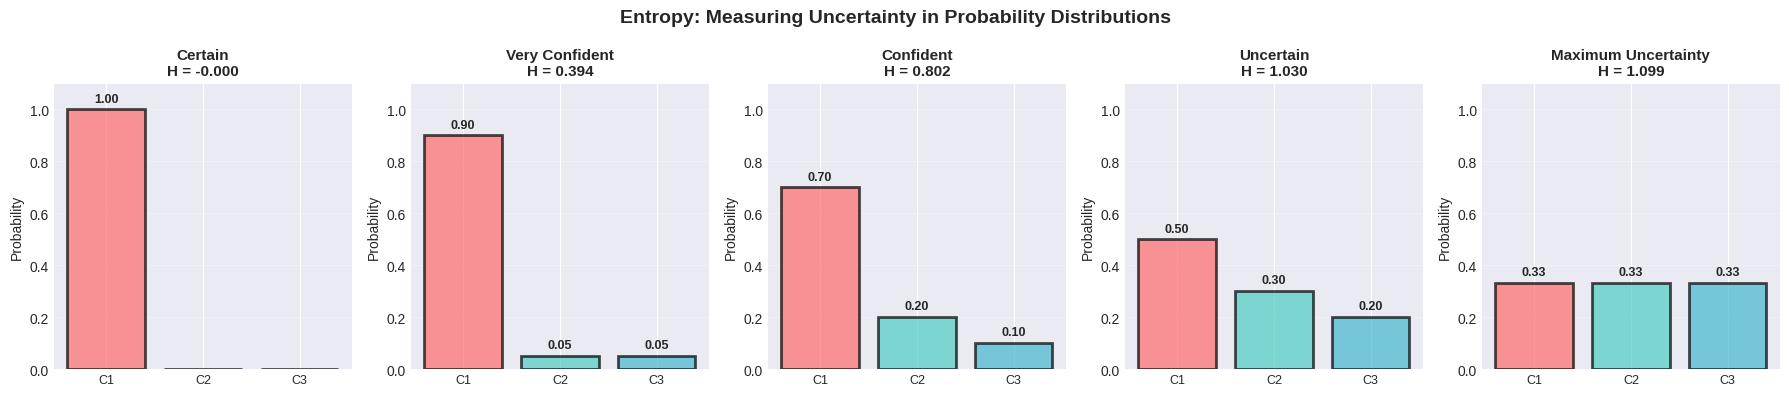


📊 Key Observations:
  • Entropy = 0 when certain (one probability = 1)
  • Entropy increases as distribution becomes more uniform
  • Maximum entropy = 1.099 nats for 3 classes


In [13]:
distributions = [
    ([1.0, 0.0, 0.0], "Certain"),
    ([0.9, 0.05, 0.05], "Very Confident"),
    ([0.7, 0.2, 0.1], "Confident"),
    ([0.5, 0.3, 0.2], "Uncertain"),
    ([1/3, 1/3, 1/3], "Maximum Uncertainty")
]

fig, axes = plt.subplots(1, 5, figsize=(18, 4))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for idx, (dist, label) in enumerate(distributions):
    ent = entropy(dist)
    axes[idx].bar([0, 1, 2], dist, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
    axes[idx].set_ylim(0, 1.1)
    axes[idx].set_xticks([0, 1, 2])
    axes[idx].set_xticklabels(['C1', 'C2', 'C3'], fontsize=9)
    axes[idx].set_ylabel('Probability', fontsize=10)
    axes[idx].set_title(f'{label}\nH = {ent:.3f}', fontsize=11, fontweight='bold')
    axes[idx].grid(True, alpha=0.3, axis='y')
    
    for i, p in enumerate(dist):
        if p > 0.02:
            axes[idx].text(i, p + 0.03, f'{p:.2f}', ha='center', fontsize=9, fontweight='bold')

plt.suptitle('Entropy: Measuring Uncertainty in Probability Distributions', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n📊 Key Observations:")
print("  • Entropy = 0 when certain (one probability = 1)")
print("  • Entropy increases as distribution becomes more uniform")
print(f"  • Maximum entropy = {np.log(3):.3f} nats for 3 classes")

## 3. Cross-Entropy: Measuring Distribution Difference

### 🎯 The Intuition

**Cross-entropy** measures how different two probability distributions are.

**In machine learning:**
- $p$ = **true distribution** (actual labels, e.g., [0, 1, 0])
- $q$ = **predicted distribution** (model output, e.g., [0.1, 0.7, 0.2])
- Cross-entropy tells us how "surprised" we are by predictions

### 📐 Mathematical Definition

$$H(p, q) = -\sum_{i=1}^{n} p_i \log(q_i)$$

**Key properties:**
- $H(p, q) \geq H(p)$ (always at least as large as entropy)
- $H(p, q) = H(p)$ when $p = q$ (perfect prediction)
- Larger when predictions are far from truth
- **This is our loss function!**

### 🔗 Relationship to KL Divergence

$$H(p, q) = H(p) + D_{KL}(p \| q)$$

Since $H(p)$ is constant during training, **minimizing cross-entropy = minimizing KL divergence!**

In [14]:
def cross_entropy(p, q):
    """
    Calculate cross-entropy between two distributions.
    H(p, q) = -Σ p_i * log(q_i)
    """
    p = np.array(p)
    q = np.array(q)
    q = np.clip(q, 1e-15, 1.0)  # Avoid log(0)
    return -np.sum(p * np.log(q))

# Example: True label is class 2
p_true = [0, 1, 0]

print("🎯 Cross-Entropy Examples:")
print(f"True distribution: {p_true} (Class 2)\n")

predictions = [
    ([0.0, 1.0, 0.0], "Perfect"),
    ([0.1, 0.8, 0.1], "Good"),
    ([0.2, 0.5, 0.3], "Mediocre"),
    ([0.4, 0.3, 0.3], "Bad"),
    ([0.9, 0.05, 0.05], "Terrible (confident but wrong)")
]

for pred, label in predictions:
    ce = cross_entropy(p_true, pred)
    print(f"{label:30s}: {pred} → CE = {ce:.4f}")

🎯 Cross-Entropy Examples:
True distribution: [0, 1, 0] (Class 2)

Perfect                       : [0.0, 1.0, 0.0] → CE = -0.0000
Good                          : [0.1, 0.8, 0.1] → CE = 0.2231
Mediocre                      : [0.2, 0.5, 0.3] → CE = 0.6931
Bad                           : [0.4, 0.3, 0.3] → CE = 1.2040
Terrible (confident but wrong): [0.9, 0.05, 0.05] → CE = 2.9957


### Visualizing Cross-Entropy Loss

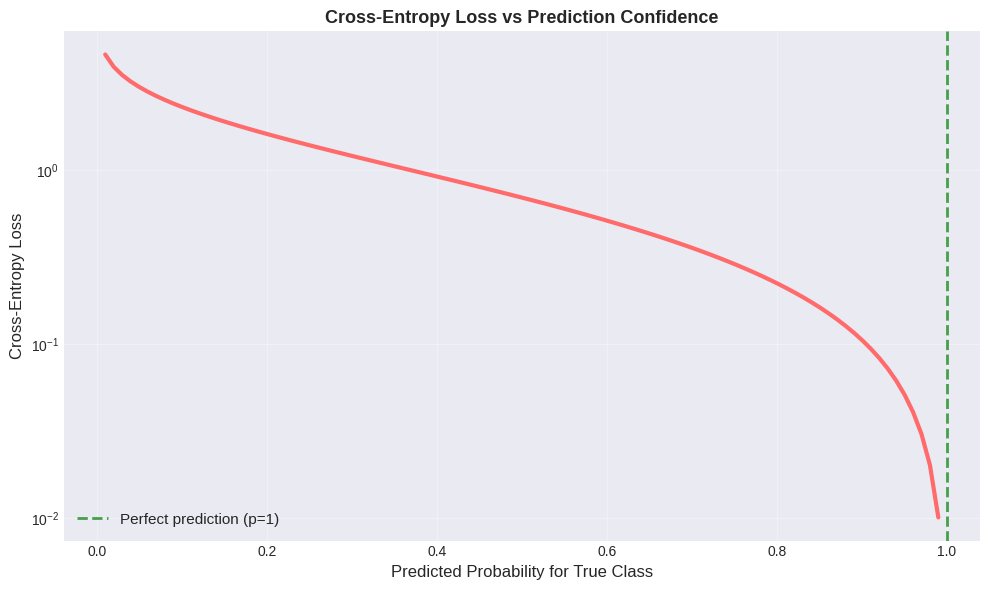


📊 Key Observations:
  • Loss → 0 as prediction → perfect
  • Loss → ∞ as prediction → 0 for true class
  • Heavily penalizes confident wrong predictions


In [15]:
# Vary predicted probability for true class
p_class2 = np.linspace(0.01, 0.99, 100)
ce_values = []

for p2 in p_class2:
    p1 = p3 = (1 - p2) / 2
    q = [p1, p2, p3]
    ce_values.append(cross_entropy([0, 1, 0], q))

plt.figure(figsize=(10, 6))
plt.plot(p_class2, ce_values, linewidth=3, color='#FF6B6B')
plt.axvline(x=1.0, color='green', linestyle='--', linewidth=2, alpha=0.7, 
            label='Perfect prediction (p=1)')
plt.xlabel('Predicted Probability for True Class', fontsize=12)
plt.ylabel('Cross-Entropy Loss', fontsize=12)
plt.title('Cross-Entropy Loss vs Prediction Confidence', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.yscale('log')
plt.tight_layout()
plt.show()

print("\n📊 Key Observations:")
print("  • Loss → 0 as prediction → perfect")
print("  • Loss → ∞ as prediction → 0 for true class")
print("  • Heavily penalizes confident wrong predictions")

## 4. Softmax: Converting Logits to Probabilities

### 🎯 The Problem

Neural networks output **raw scores** (logits): `[2.5, -1.3, 0.8]`

But we need **probabilities** that:
1. Are between 0 and 1
2. Sum to 1
3. Represent confidence in each class

**Softmax solves this!**

### 📐 Mathematical Definition

$$\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{n} e^{z_j}}$$

**Key properties:**
- Output always in (0, 1)
- Outputs sum to exactly 1
- Differentiable everywhere
- Emphasizes maximum value (soft argmax)

In [16]:
def softmax(z):
    """
    Compute softmax activation.
    softmax(z_i) = e^(z_i) / Σ e^(z_j)
    """
    z = np.array(z)
    exp_z = np.exp(z - np.max(z))  # Numerical stability # WHY subtract np.max(z)? # Problem: exp() can overflow with large numbers, # Solution: Subtract the maximum value first
    return exp_z / np.sum(exp_z)

print("🎯 Softmax Examples:\n")

examples = [
    ([3.0, 1.0, 0.2], "Clear winner"),
    ([1.0, 0.9, 0.8], "Close competition"),
    ([0.0, 0.0, 0.0], "All equal"),
    ([-1.0, -2.0, -3.0], "Negative logits")
]

for logits, label in examples:
    probs = softmax(logits)
    print(f"{label:20s}: {logits}")
    print(f"{'':20s}  → {probs}")
    print(f"{'':20s}  Sum = {np.sum(probs):.6f}\n")

🎯 Softmax Examples:

Clear winner        : [3.0, 1.0, 0.2]
                      → [0.8360188  0.11314284 0.05083836]
                      Sum = 1.000000

Close competition   : [1.0, 0.9, 0.8]
                      → [0.3671654  0.33222499 0.30060961]
                      Sum = 1.000000

All equal           : [0.0, 0.0, 0.0]
                      → [0.33333333 0.33333333 0.33333333]
                      Sum = 1.000000

Negative logits     : [-1.0, -2.0, -3.0]
                      → [0.66524096 0.24472847 0.09003057]
                      Sum = 1.000000



### Visualizing Softmax Transformation

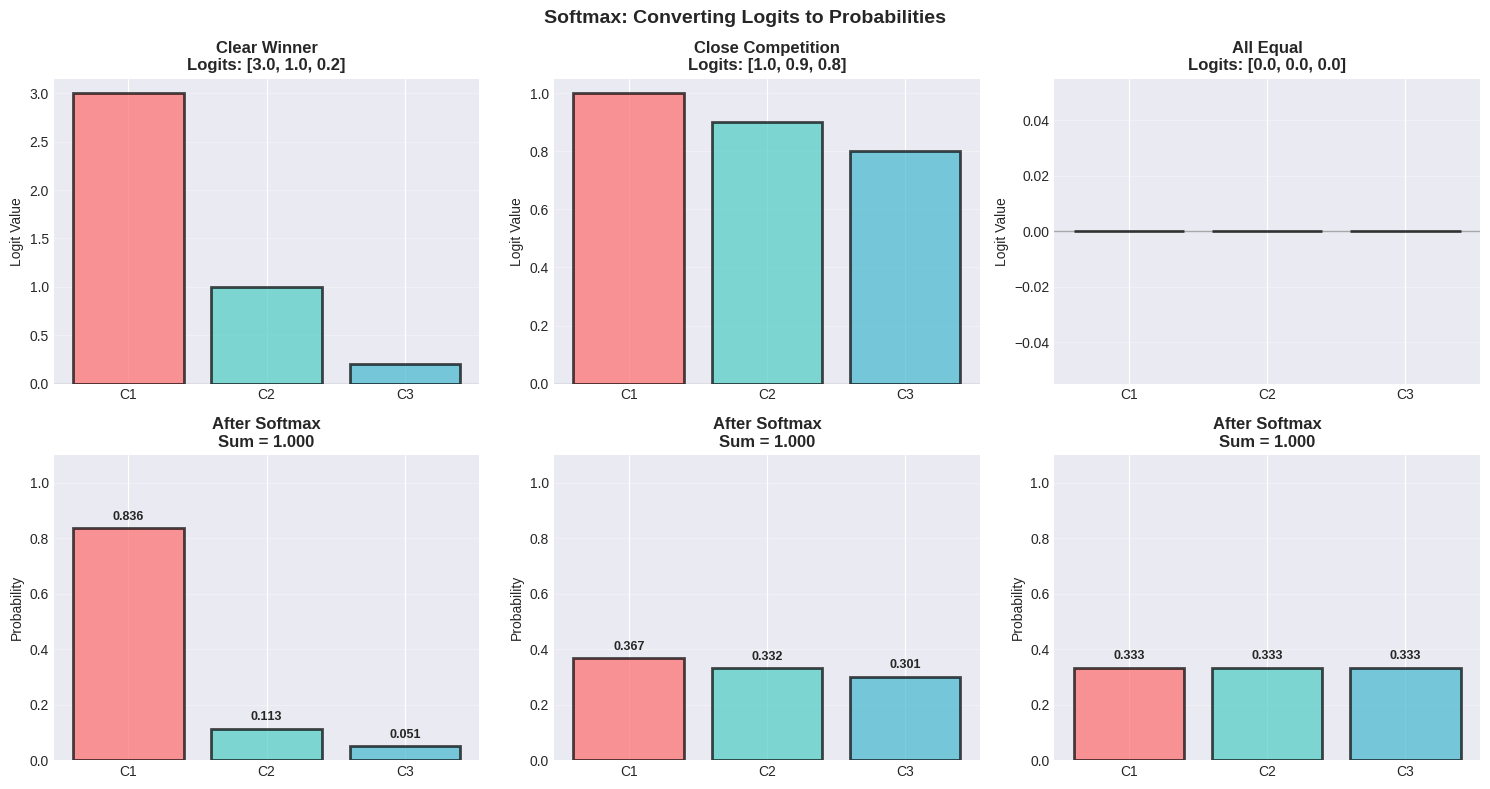

In [17]:
logit_examples = [
    ([3.0, 1.0, 0.2], "Clear Winner"),
    ([1.0, 0.9, 0.8], "Close Competition"),
    ([0.0, 0.0, 0.0], "All Equal")
]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for idx, (logits, label) in enumerate(logit_examples):
    probs = softmax(logits)
    
    # Plot logits
    axes[0, idx].bar([0, 1, 2], logits, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
    axes[0, idx].axhline(y=0, color='k', linestyle='-', linewidth=1, alpha=0.3)
    axes[0, idx].set_xticks([0, 1, 2])
    axes[0, idx].set_xticklabels(['C1', 'C2', 'C3'])
    axes[0, idx].set_ylabel('Logit Value')
    axes[0, idx].set_title(f'{label}\nLogits: {logits}', fontweight='bold')
    axes[0, idx].grid(True, alpha=0.3, axis='y')
    
    # Plot probabilities
    axes[1, idx].bar([0, 1, 2], probs, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
    axes[1, idx].set_ylim(0, 1.1)
    axes[1, idx].set_xticks([0, 1, 2])
    axes[1, idx].set_xticklabels(['C1', 'C2', 'C3'])
    axes[1, idx].set_ylabel('Probability')
    axes[1, idx].set_title(f'After Softmax\nSum = {np.sum(probs):.3f}', fontweight='bold')
    axes[1, idx].grid(True, alpha=0.3, axis='y')
    
    for i, p in enumerate(probs):
        axes[1, idx].text(i, p + 0.03, f'{p:.3f}', ha='center', fontsize=9, fontweight='bold')

plt.suptitle('Softmax: Converting Logits to Probabilities', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. The Deep Connection: Entropy and Softmax

### 🎯 Maximum Entropy Principle

**Key Insight**: Softmax is the **unique** function that maximizes entropy subject to constraints!

**The Problem:**
Given constraints (expected values), what probability distribution should we choose?

**The Answer:**
The distribution that **maximizes entropy** - makes the least committal prediction.

**Mathematical Statement:**

Maximize: $H(p) = -\sum_i p_i \log p_i$

Subject to:
1. $\sum_i p_i = 1$ (valid probability)
2. $\sum_i p_i f_i = \bar{f}$ (expected value constraint)

**Solution:** $p_i = \frac{e^{\lambda f_i}}{Z}$ where $Z = \sum_j e^{\lambda f_j}$

This is exactly the **softmax function**!

### 🔗 Why This Matters

1. **Theoretical justification**: Softmax isn't arbitrary
2. **Information theory**: Makes minimal assumptions
3. **Connection to physics**: Same as Boltzmann distribution
4. **Calibration**: Maximum entropy → well-calibrated probabilities

In [18]:
# Demonstrate: Softmax maximizes entropy
logits = [2.0, 1.0, 0.5]

softmax_probs = softmax(logits)
softmax_entropy = entropy(softmax_probs)

print("🎯 Maximum Entropy Demonstration\n")
print(f"Logits: {logits}")
print(f"Softmax probabilities: {softmax_probs}")
print(f"Softmax entropy: {softmax_entropy:.4f} nats\n")

print("Comparing with other normalization methods:\n")

# Simple normalization
simple_norm = np.array(logits) / np.sum(logits)
simple_entropy = entropy(simple_norm)
print(f"Simple normalization: {simple_norm}")
print(f"Entropy: {simple_entropy:.4f} (Δ = {softmax_entropy - simple_entropy:.4f})\n")

# Squared normalization
squared = np.array(logits) ** 2
squared_norm = squared / np.sum(squared)
squared_entropy = entropy(squared_norm)
print(f"Squared normalization: {squared_norm}")
print(f"Entropy: {squared_entropy:.4f} (Δ = {softmax_entropy - squared_entropy:.4f})\n")

print("✅ Softmax has the HIGHEST entropy!")
print("   This means it makes the least committal prediction given the logits.")

🎯 Maximum Entropy Demonstration

Logits: [2.0, 1.0, 0.5]
Softmax probabilities: [0.62853172 0.2312239  0.14024438]
Softmax entropy: 0.9060 nats

Comparing with other normalization methods:

Simple normalization: [0.57142857 0.28571429 0.14285714]
Entropy: 0.9557 (Δ = -0.0497)

Squared normalization: [0.76190476 0.19047619 0.04761905]
Entropy: 0.6680 (Δ = 0.2379)

✅ Softmax has the HIGHEST entropy!
   This means it makes the least committal prediction given the logits.


## 6. Complete Example: Multiclass Classification

Let's put everything together with the Iris dataset.

In [19]:
# Load and prepare data
iris = load_iris()
X = iris.data[:, :2]  # Use first 2 features for visualization
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# One-hot encode labels
def one_hot_encode(y, num_classes=3):
    return np.eye(num_classes)[y]

y_train_onehot = one_hot_encode(y_train)
y_test_onehot = one_hot_encode(y_test)

print("Dataset Information:")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Features: {X_train.shape[1]}")
print(f"Classes: {len(np.unique(y))}")
print(f"Class names: {iris.target_names}")

Dataset Information:
Training samples: 105
Test samples: 45
Features: 2
Classes: 3
Class names: ['setosa' 'versicolor' 'virginica']


### Simple Neural Network Implementation

In [20]:
class MulticlassNetwork:
    """
    Simple neural network for multiclass classification.
    Architecture: Input -> Hidden (ReLU) -> Output (Softmax)
    Loss: Cross-Entropy
    """
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.1):
        self.lr = learning_rate
        self.W1 = np.random.randn(input_size, hidden_size) * 0.1
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * 0.1
        self.b2 = np.zeros((1, output_size))
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_derivative(self, x):
        return (x > 0).astype(float)
    
    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)
    
    def forward(self, X):
        self.X = X
        self.z1 = X @ self.W1 + self.b1
        self.h1 = self.relu(self.z1)
        self.z2 = self.h1 @ self.W2 + self.b2
        self.y_pred = self.softmax(self.z2)
        return self.y_pred
    
    def compute_loss(self, y_true, y_pred):
        """Cross-entropy loss"""
        n = len(y_true)
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        return -np.sum(y_true * np.log(y_pred)) / n
    
    def backward(self, y_true):
        n = len(y_true)
        dL_dz2 = (self.y_pred - y_true) / n
        dL_dW2 = self.h1.T @ dL_dz2
        dL_db2 = np.sum(dL_dz2, axis=0, keepdims=True)
        
        dL_dh1 = dL_dz2 @ self.W2.T
        dL_dz1 = dL_dh1 * self.relu_derivative(self.z1)
        dL_dW1 = self.X.T @ dL_dz1
        dL_db1 = np.sum(dL_dz1, axis=0, keepdims=True)
        
        self.W1 -= self.lr * dL_dW1
        self.b1 -= self.lr * dL_db1
        self.W2 -= self.lr * dL_dW2
        self.b2 -= self.lr * dL_db2
    
    def accuracy(self, y_true, y_pred):
        predictions = np.argmax(y_pred, axis=1)
        true_labels = np.argmax(y_true, axis=1)
        return np.mean(predictions == true_labels)

# Train network
print("Training Neural Network...\n")
model = MulticlassNetwork(input_size=2, hidden_size=10, output_size=3, learning_rate=0.1)
train_losses = []
test_accs = []

for epoch in range(1000):
    y_pred_train = model.forward(X_train)
    train_loss = model.compute_loss(y_train_onehot, y_pred_train)
    model.backward(y_train_onehot)
    
    y_pred_test = model.forward(X_test)
    test_acc = model.accuracy(y_test_onehot, y_pred_test)
    
    train_losses.append(train_loss)
    test_accs.append(test_acc)
    
    if (epoch + 1) % 200 == 0:
        print(f"Epoch {epoch+1}: Loss = {train_loss:.4f}, Test Acc = {test_acc:.4f}")

print(f"\n✅ Training Complete! Final Test Accuracy: {test_accs[-1]:.2%}")

Training Neural Network...

Epoch 200: Loss = 0.5335, Test Acc = 0.8222
Epoch 400: Loss = 0.4420, Test Acc = 0.8222
Epoch 600: Loss = 0.4141, Test Acc = 0.8000
Epoch 800: Loss = 0.3998, Test Acc = 0.8000
Epoch 1000: Loss = 0.3919, Test Acc = 0.8000

✅ Training Complete! Final Test Accuracy: 80.00%


### Visualize Training Progress

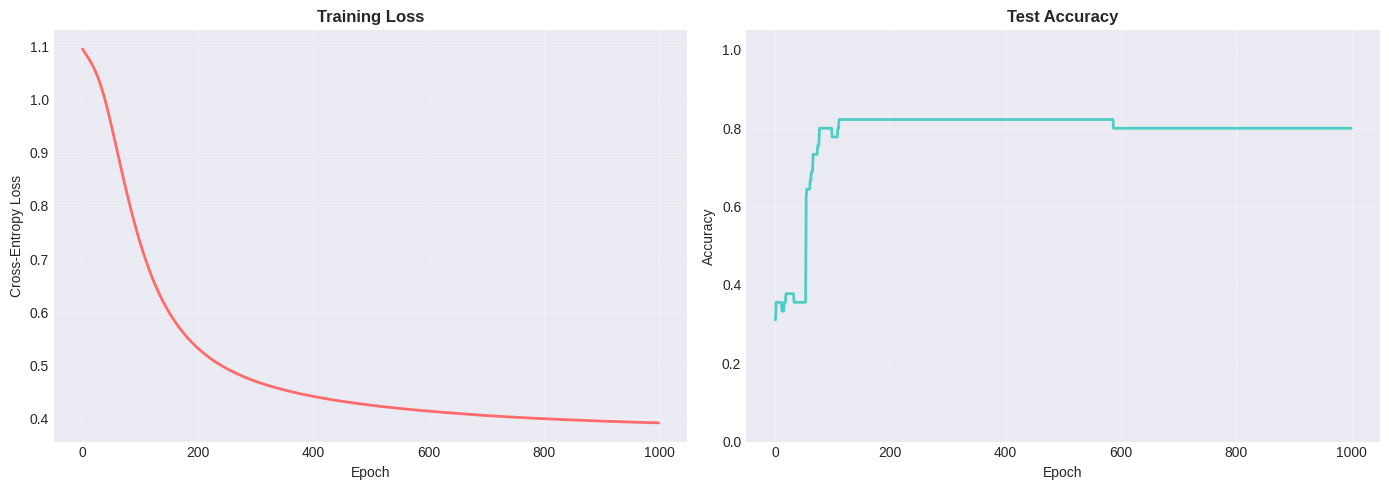

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(train_losses, linewidth=2, color='#FF6B6B')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Cross-Entropy Loss')
axes[0].set_title('Training Loss', fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(test_accs, linewidth=2, color='#4ECDC4')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Test Accuracy', fontweight='bold')
axes[1].set_ylim(0, 1.05)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Summary: Putting It All Together

### 🎯 The Complete Picture

| Concept | Purpose | Formula | Key Insight |
|---------|---------|---------|-------------|
| **Entropy** | Measure uncertainty | $H(p) = -\sum p_i \log p_i$ | Maximum when uniform |
| **Cross-Entropy** | Measure prediction error | $H(p,q) = -\sum p_i \log q_i$ | Perfect loss for classification |
| **Softmax** | Convert logits to probabilities | $\text{softmax}(z_i) = \frac{e^{z_i}}{\sum e^{z_j}}$ | Maximizes entropy given constraints |

### 🔗 How They Work Together

1. **Neural network outputs logits** (raw scores): `[2.5, -1.3, 0.8]`
2. **Softmax converts to probabilities**: `[0.85, 0.02, 0.13]`
3. **Cross-entropy measures error** against true labels: `[0, 1, 0]`
4. **Backpropagation updates weights** to minimize cross-entropy
5. **Entropy provides theoretical foundation** for why this works

### 📊 Key Takeaways

1. **Entropy measures uncertainty** - Higher entropy = more uncertain
2. **Cross-entropy is the perfect loss** - Strong gradients, probabilistic interpretation
3. **Softmax is principled** - Maximizes entropy subject to constraints
4. **They form a complete system** - Theoretically justified and practically effective

### 💡 Practical Tips

1. **Always use softmax + cross-entropy** for multiclass classification
2. **Monitor entropy during training** - Can indicate overconfidence or uncertainty
3. **Use temperature for calibration** - Adjust confidence of predictions
4. **Label smoothing adds entropy** - Prevents overconfident predictions

---

**🎓 Congratulations!** You now understand the deep connection between entropy, cross-entropy, and softmax, and how they work together to enable effective multiclass classification!